<a href="https://colab.research.google.com/github/ManasThinkPad/Supply_Chain/blob/main/Supply_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns in dataset: Index(['Product type', 'SKU', 'Price', 'Availability',
       'Number of products sold', 'Revenue generated', 'Customer demographics',
       'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
       'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location',
       'Lead time', 'Production volumes', 'Manufacturing lead time',
       'Manufacturing costs', 'Inspection results', 'Defect rates',
       'Transportation modes', 'Routes', 'Costs'],
      dtype='object')
  Product type   SKU      Price  Availability  previous_demand  \
0     haircare  SKU0  69.808006            55              802   
1     skincare  SKU1  14.843523            95              736   
2     haircare  SKU2  11.319683            34                8   
3     skincare  SKU3  61.163343            68               83   
4     skincare  SKU4   4.805496            26              871   

   Revenue generated Customer demographics  inventory_level  Lead times  \
0        8661

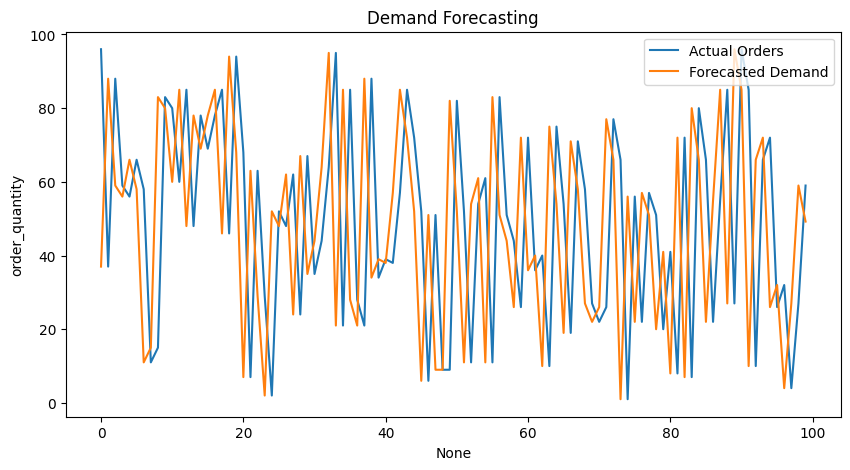

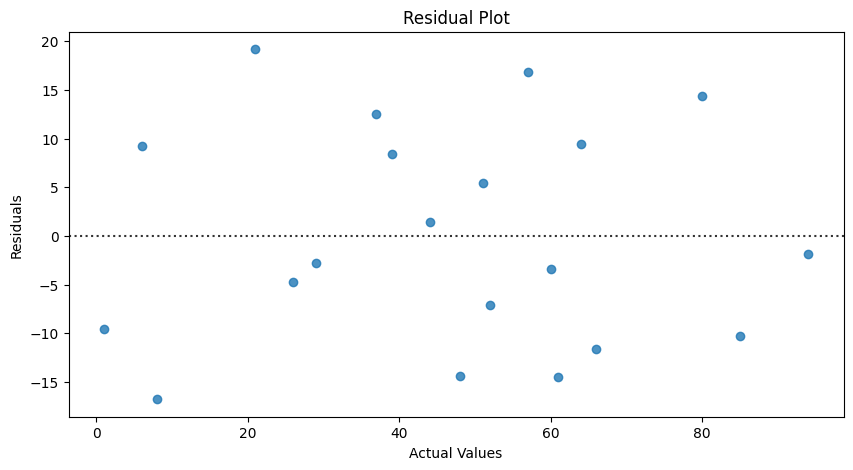

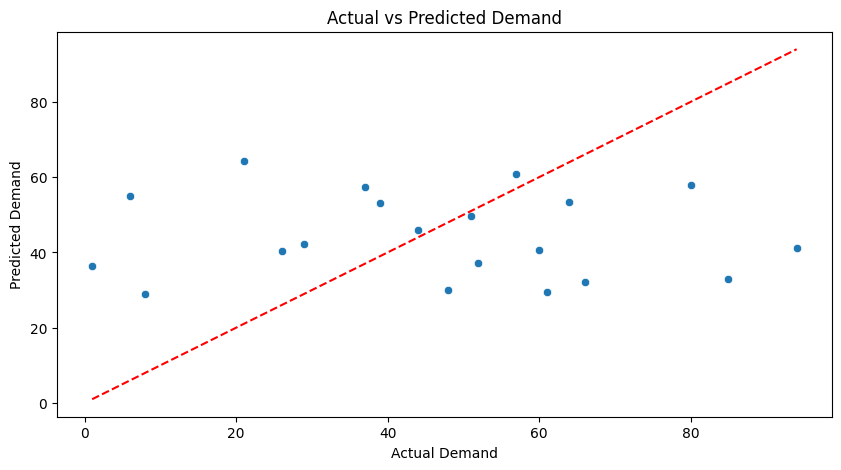

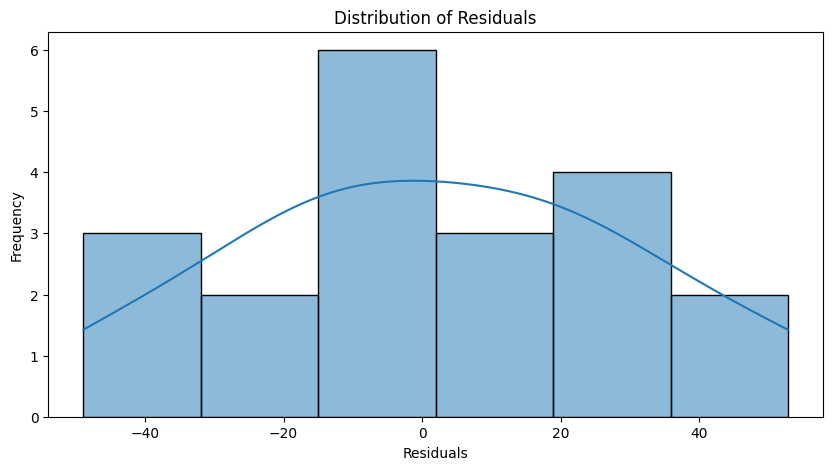

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import linprog

# Load Dataset
file_path = "/content/supply_chain_data.csv"
df = pd.read_csv(file_path)

# Check and clean column names
df.columns = df.columns.str.strip()
print("Columns in dataset:", df.columns)

# Rename dataset columns to match required names
df.rename(columns={
    'Number of products sold': 'previous_demand',
    'Stock levels': 'inventory_level',
    'Order quantities': 'order_quantity',
    'Lead time': 'lead_time',
    'Costs': 'unit_cost'
}, inplace=True)

# Ensure required columns exist
required_columns = {'previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost'}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    raise ValueError(f"Missing columns in dataset: {missing_columns}")

# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

# Feature Engineering: Handling missing values
df = df.dropna()

# Demand Forecasting using Machine Learning
# Selecting relevant features for demand prediction
features = ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time']
target = 'demand_forecast'

# Ensure 'order_quantity' column exists before proceeding
df[target] = df['order_quantity'].shift(-1).fillna(df['order_quantity'].mean())
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Regressor
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# Save results to a JSON file
results = {
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "R² Score": r2
}
with open("results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

# Inventory Optimization using Linear Programming
# Objective: Minimize cost while meeting demand
costs = df['unit_cost'].values
demands = df['demand_forecast'].values
supply_limits = df['inventory_level'].values

# Defining constraints
A_eq = np.ones((1, len(costs)))
b_eq = [sum(demands)]
A_ub = np.identity(len(costs))
b_ub = supply_limits

# Solving the optimization problem
res = linprog(costs, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, method='highs')

# Results
if res.success:
    print("Optimal inventory allocation:", res.x)
    print("Minimum cost:", res.fun)
    results["Optimal Inventory Allocation"] = res.x.tolist()
    results["Minimum Cost"] = res.fun
else:
    print("Optimization failed. Trying an alternative method...")
    results["Optimal Inventory Allocation"] = "Optimization failed"
    results["Minimum Cost"] = "N/A"

    # Alternative approach: Relax constraints slightly and retry
    b_eq_relaxed = [sum(demands) * 0.95]  # Allow a small flexibility in demand
    res_relaxed = linprog(costs, A_eq=A_eq, b_eq=b_eq_relaxed, A_ub=A_ub, b_ub=b_ub, method='highs')

    if res_relaxed.success:
        print("Alternative optimization succeeded.")
        results["Alternative Optimal Inventory Allocation"] = res_relaxed.x.tolist()
        results["Alternative Minimum Cost"] = res_relaxed.fun
    else:
        print("Alternative optimization also failed. Consider revising constraints.")
        results["Alternative Optimal Inventory Allocation"] = "Failed"
        results["Alternative Minimum Cost"] = "N/A"

# Save optimization results to JSON
with open("results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

# Visualization
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y=df['order_quantity'], label='Actual Orders')
sns.lineplot(x=df.index, y=df['demand_forecast'], label='Forecasted Demand')
plt.title('Demand Forecasting')
plt.legend()
plt.show()

# Residual Plot
plt.figure(figsize=(10, 5))
sns.residplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.title("Residual Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.show()

# Scatter Plot of Predictions vs Actual Values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


Columns in dataset: Index(['Product type', 'SKU', 'Price', 'Availability',
       'Number of products sold', 'Revenue generated', 'Customer demographics',
       'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
       'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location',
       'Lead time', 'Production volumes', 'Manufacturing lead time',
       'Manufacturing costs', 'Inspection results', 'Defect rates',
       'Transportation modes', 'Routes', 'Costs'],
      dtype='object')
  Product type   SKU      Price  Availability  previous_demand  \
0     haircare  SKU0  69.808006            55              802   
1     skincare  SKU1  14.843523            95              736   
2     haircare  SKU2  11.319683            34                8   
3     skincare  SKU3  61.163343            68               83   
4     skincare  SKU4   4.805496            26              871   

   Revenue generated Customer demographics  inventory_level  Lead times  \
0        8661

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 2860.4011 - mae: 46.6740 - val_loss: 2774.5242 - val_mae: 46.1820
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2904.4761 - mae: 47.6586 - val_loss: 2743.4004 - val_mae: 45.8453
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3058.4597 - mae: 48.4000 - val_loss: 2708.5264 - val_mae: 45.4607
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2880.0288 - mae: 45.6700 - val_loss: 2664.8589 - val_mae: 44.9803
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3143.4976 - mae: 49.7506 - val_loss: 2608.4797 - val_mae: 44.3943
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3025.9617 - mae: 48.3872 - val_loss: 2535.4338 - val_mae: 43.6199
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2980.0042 - mae: 47.9677 - val_loss: 2439.0630 - val_mae: 42.5730
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2783.0913 - mae: 45.2442 - val_loss: 2317.9019 - val_mae: 41.2151
Epoch 9

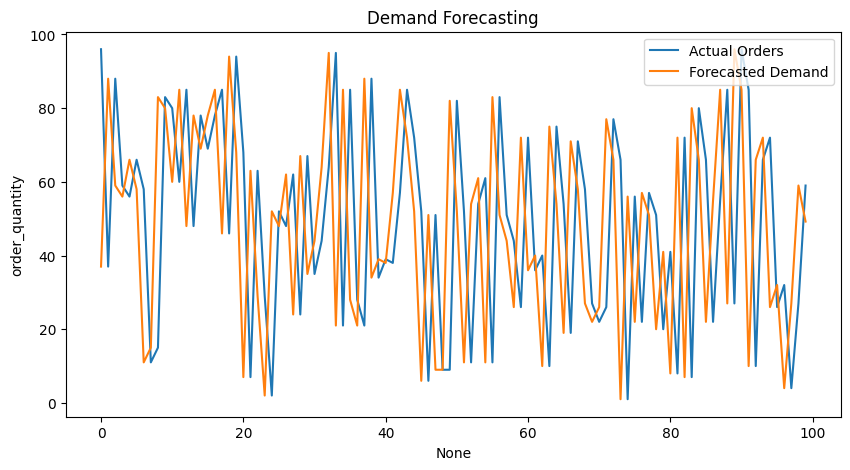

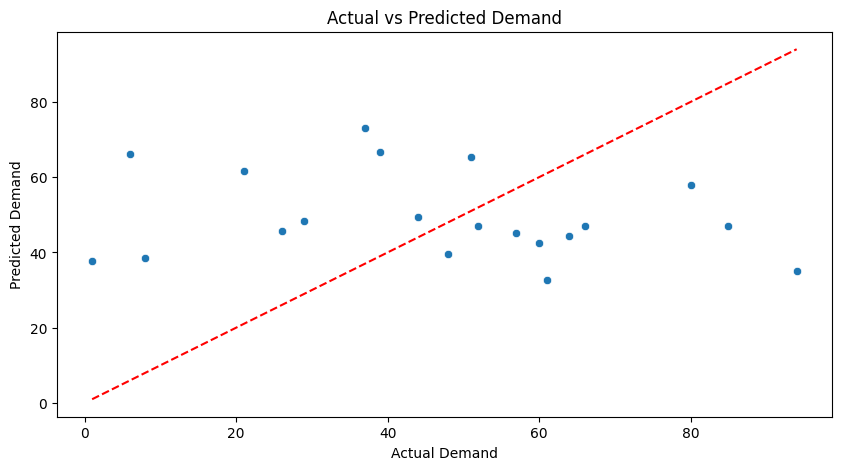

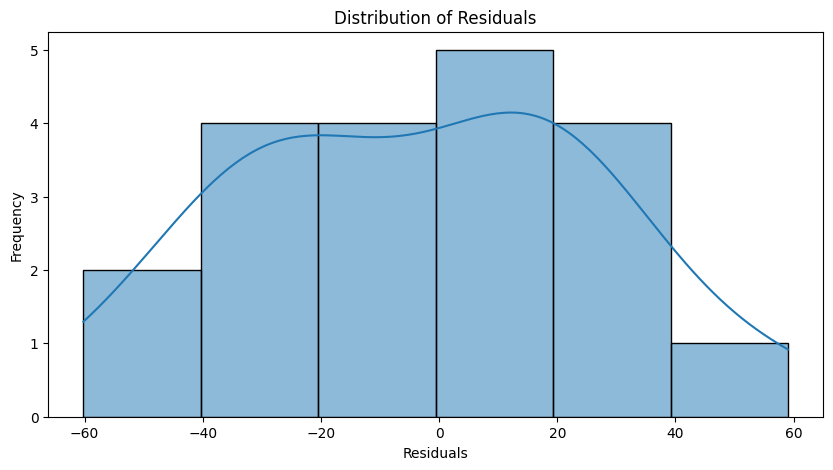

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import linprog
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load Dataset
file_path = "/content/supply_chain_data.csv"
df = pd.read_csv(file_path)

# Check and clean column names
df.columns = df.columns.str.strip()
print("Columns in dataset:", df.columns)

# Rename dataset columns to match required names
df.rename(columns={
    'Number of products sold': 'previous_demand',
    'Stock levels': 'inventory_level',
    'Order quantities': 'order_quantity',
    'Lead time': 'lead_time',
    'Costs': 'unit_cost'
}, inplace=True)

# Ensure required columns exist
required_columns = {'previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost'}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    raise ValueError(f"Missing columns in dataset: {missing_columns}")

# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

# Feature Engineering: Handling missing values
df = df.dropna()

# Demand Forecasting using Deep Learning
features = ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time']
target = 'demand_forecast'

df[target] = df['order_quantity'].shift(-1).fillna(df['order_quantity'].mean())
X = df[features]
y = df[target]

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Deep Learning Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, verbose=1)

# Make predictions
y_pred = model.predict(X_test).flatten()

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# Save results to a JSON file
results = {
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "R² Score": r2
}
with open("results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

# Visualization
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y=df['order_quantity'], label='Actual Orders')
sns.lineplot(x=df.index, y=df['demand_forecast'], label='Forecasted Demand')
plt.title('Demand Forecasting')
plt.legend()
plt.show()

# Scatter Plot of Predictions vs Actual Values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


Columns in dataset: Index(['Product type', 'SKU', 'Price', 'Availability',
       'Number of products sold', 'Revenue generated', 'Customer demographics',
       'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
       'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location',
       'Lead time', 'Production volumes', 'Manufacturing lead time',
       'Manufacturing costs', 'Inspection results', 'Defect rates',
       'Transportation modes', 'Routes', 'Costs'],
      dtype='object')
  Product type   SKU      Price  Availability  previous_demand  \
0     haircare  SKU0  69.808006            55              802   
1     skincare  SKU1  14.843523            95              736   
2     haircare  SKU2  11.319683            34                8   
3     skincare  SKU3  61.163343            68               83   
4     skincare  SKU4   4.805496            26              871   

   Revenue generated Customer demographics  inventory_level  Lead times  \
0        8661

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.1796 - mae: 0.5269 - val_loss: 0.1369 - val_mae: 0.4496 - learning_rate: 0.0010
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1321 - mae: 0.4432 - val_loss: 0.1206 - val_mae: 0.4137 - learning_rate: 0.0010
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1190 - mae: 0.4147 - val_loss: 0.1024 - val_mae: 0.3744 - learning_rate: 0.0010
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1064 - mae: 0.3937 - val_loss: 0.0858 - val_mae: 0.3373 - learning_rate: 0.0010
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0756 - mae: 0.3286 - val_loss: 0.0673 - val_mae: 0.2960 - learning_rate: 0.0010
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0645 - mae: 0.3099 - val_loss: 0.0554 - val_mae: 0.2700 - learning_rate: 0.0010
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0490 - mae: 0.2708 - val_loss: 0.0458 - val_mae: 0.2558 - learning_rate: 0.0010
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━

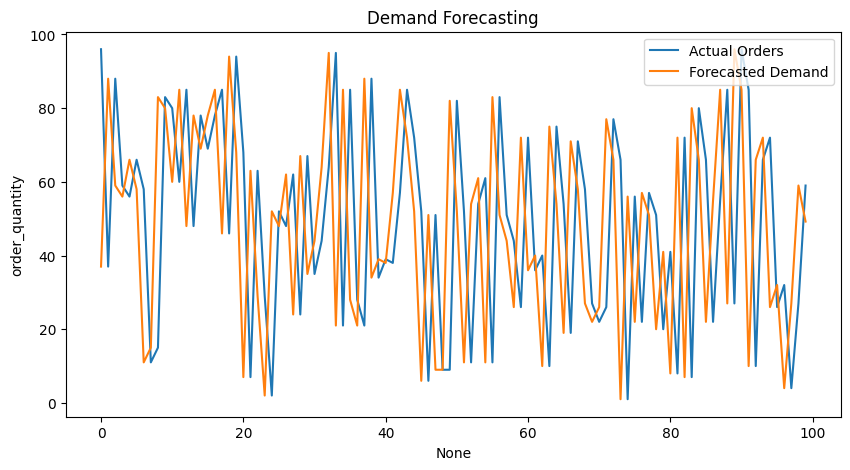

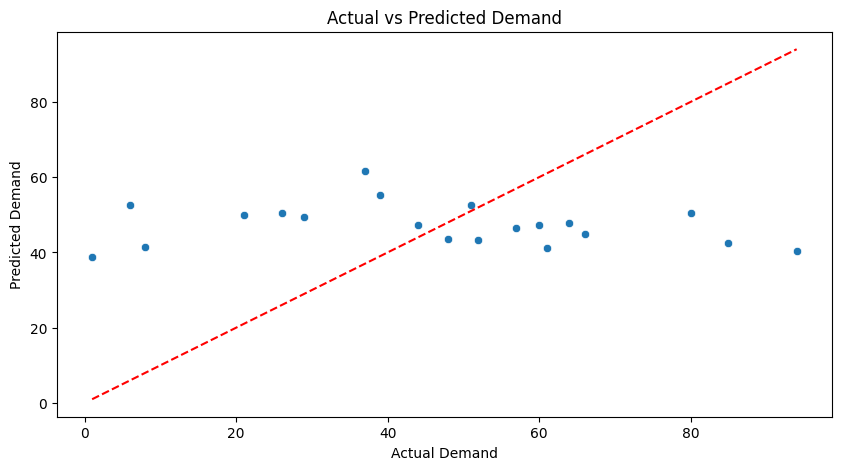

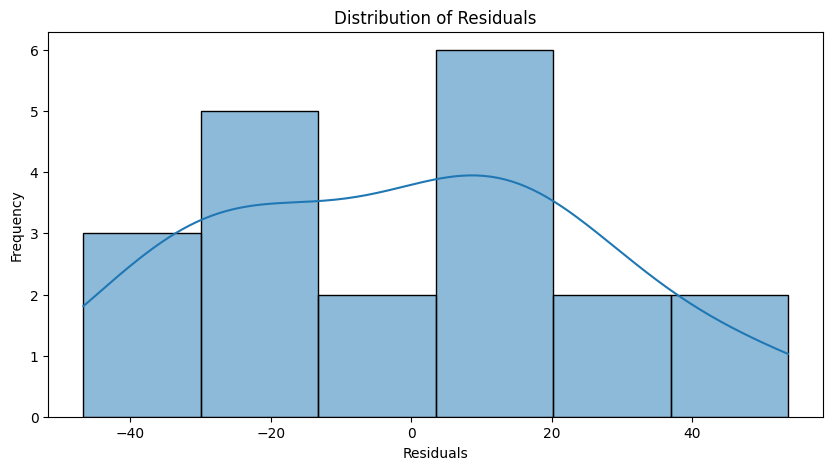

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Dataset
file_path = "/content/supply_chain_data.csv"
df = pd.read_csv(file_path)

# Check and clean column names
df.columns = df.columns.str.strip()
print("Columns in dataset:", df.columns)

# Rename dataset columns to match required names
df.rename(columns={
    'Number of products sold': 'previous_demand',
    'Stock levels': 'inventory_level',
    'Order quantities': 'order_quantity',
    'Lead time': 'lead_time',
    'Costs': 'unit_cost'
}, inplace=True)

# Ensure required columns exist
required_columns = {'previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost'}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    raise ValueError(f"Missing columns in dataset: {missing_columns}")

# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

# Feature Engineering: Handling missing values
df = df.dropna()

# Remove outliers
for col in ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost']:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Demand Forecasting using Deep Learning
features = ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time']
target = 'demand_forecast'

df[target] = df['order_quantity'].shift(-1).fillna(df['order_quantity'].mean())
X = df[features]
y = df[target]

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Improved Deep Learning Model
model = Sequential([
    Dense(256, activation='swish', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='swish'),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(1)
])

model.compile(optimizer=AdamW(learning_rate=0.001), loss=tf.keras.losses.Huber(), metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Make predictions
y_pred = model.predict(X_test).flatten()
y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# Save results to a JSON file
results = {
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "R² Score": r2
}
with open("results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

# Visualization
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y=df['order_quantity'], label='Actual Orders')
sns.lineplot(x=df.index, y=df['demand_forecast'], label='Forecasted Demand')
plt.title('Demand Forecasting')
plt.legend()
plt.show()

# Scatter Plot of Predictions vs Actual Values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


Columns in dataset: Index(['Product type', 'SKU', 'Price', 'Availability',
       'Number of products sold', 'Revenue generated', 'Customer demographics',
       'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
       'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location',
       'Lead time', 'Production volumes', 'Manufacturing lead time',
       'Manufacturing costs', 'Inspection results', 'Defect rates',
       'Transportation modes', 'Routes', 'Costs'],
      dtype='object')
  Product type   SKU      Price  Availability  previous_demand  \
0     haircare  SKU0  69.808006            55              802   
1     skincare  SKU1  14.843523            95              736   
2     haircare  SKU2  11.319683            34                8   
3     skincare  SKU3  61.163343            68               83   
4     skincare  SKU4   4.805496            26              871   

   Revenue generated Customer demographics  inventory_level  Lead times  \
0        8661

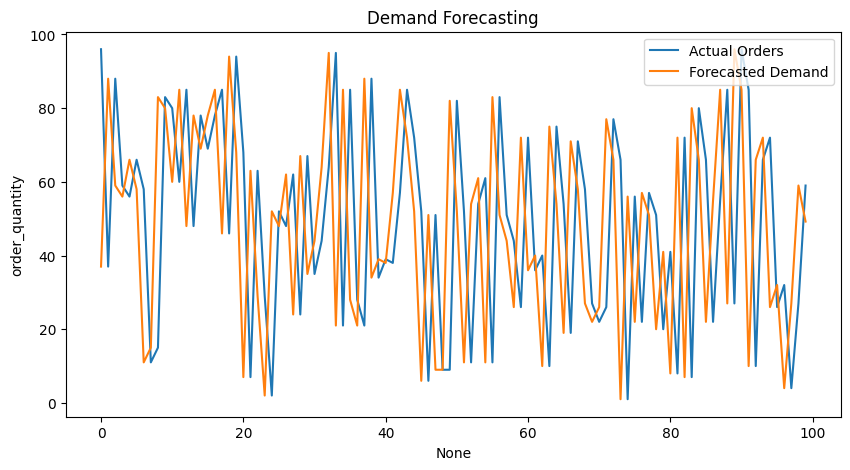

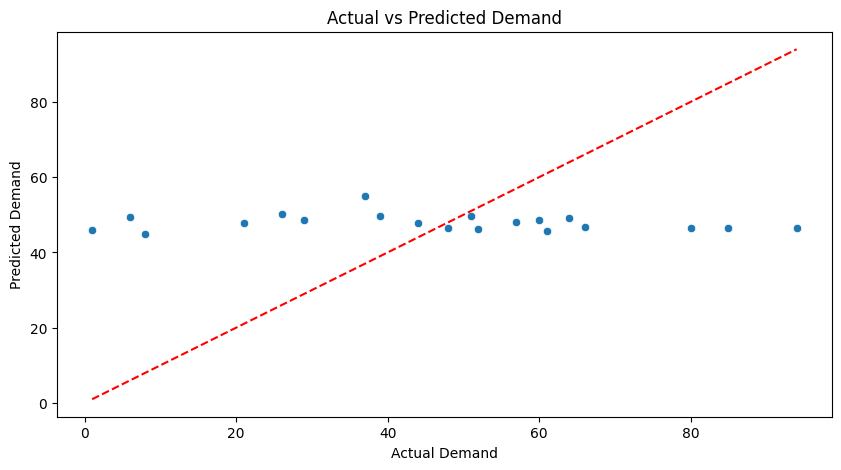

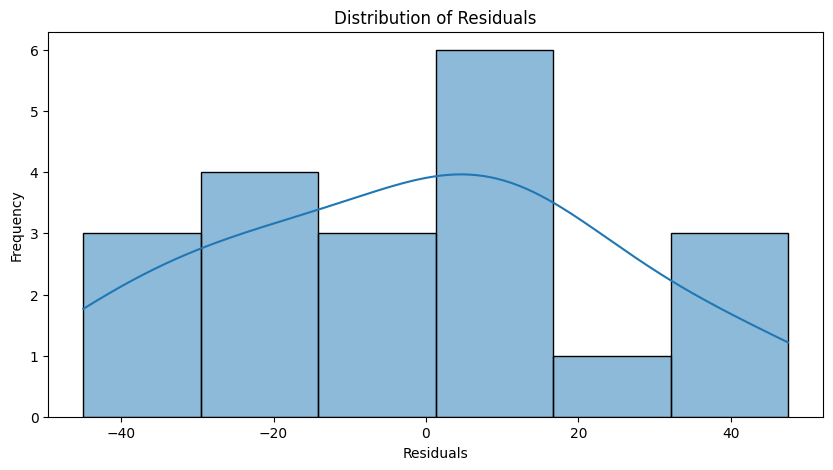

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Dataset
file_path = "/content/supply_chain_data.csv"
df = pd.read_csv(file_path)

# Check and clean column names
df.columns = df.columns.str.strip()
print("Columns in dataset:", df.columns)

# Rename dataset columns to match required names
df.rename(columns={
    'Number of products sold': 'previous_demand',
    'Stock levels': 'inventory_level',
    'Order quantities': 'order_quantity',
    'Lead time': 'lead_time',
    'Costs': 'unit_cost'
}, inplace=True)

# Ensure required columns exist
required_columns = {'previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost'}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    raise ValueError(f"Missing columns in dataset: {missing_columns}")

# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

# Feature Engineering: Handling missing values
df = df.dropna()

# Remove outliers
for col in ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost']:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Demand Forecasting using LSTM-based Deep Learning
features = ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time']
target = 'demand_forecast'

df[target] = df['order_quantity'].shift(-1).fillna(df['order_quantity'].mean())
X = df[features]
y = df[target]

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)),
    Bidirectional(LSTM(64, activation='tanh', dropout=0.2)),
    Dense(32, activation='swish'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=AdamW(learning_rate=0.001), loss=tf.keras.losses.Huber(), metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Make predictions
y_pred = model.predict(X_test).flatten()
y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# Save results to a JSON file
results = {
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "R² Score": r2
}
with open("results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

# Visualization
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y=df['order_quantity'], label='Actual Orders')
sns.lineplot(x=df.index, y=df['demand_forecast'], label='Forecasted Demand')
plt.title('Demand Forecasting')
plt.legend()
plt.show()

# Scatter Plot of Predictions vs Actual Values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [5]:
!git clone https://github.com/ManasThinkPad/Supply_Chain.git

Cloning into 'Supply_Chain'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.
Resolving deltas: 100% (1/1), done.


In [6]:
%cd Supply_Chain

/content/Supply_Chain


In [ ]:
with open("main.py", "w") as f:
    f.write
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Dataset
file_path = "/mnt/data/supply_chain_data.csv"
df = pd.read_csv(file_path)

# Check and clean column names
df.columns = df.columns.str.strip()
print("Columns in dataset:", df.columns)

# Rename dataset columns to match required names
df.rename(columns={
    'Number of products sold': 'previous_demand',
    'Stock levels': 'inventory_level',
    'Order quantities': 'order_quantity',
    'Lead time': 'lead_time',
    'Costs': 'unit_cost'
}, inplace=True)

# Ensure required columns exist
required_columns = {'previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost'}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    raise ValueError(f"Missing columns in dataset: {missing_columns}")

# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

# Feature Engineering: Handling missing values
df = df.dropna()

# Remove outliers
for col in ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time', 'unit_cost']:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Demand Forecasting using LSTM-based Deep Learning
features = ['previous_demand', 'inventory_level', 'order_quantity', 'lead_time']
target = 'demand_forecast'

df[target] = df['order_quantity'].shift(-1).fillna(df['order_quantity'].mean())
X = df[features]
y = df[target]

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)),
    Bidirectional(LSTM(64, activation='tanh', dropout=0.2)),
    Dense(32, activation='swish'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=AdamW(learning_rate=0.001), loss=tf.keras.losses.Huber(), metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Make predictions
y_pred = model.predict(X_test).flatten()
y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# Save results to a JSON file
results = {
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "R² Score": r2
}
with open("results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

# Visualization
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y=df['order_quantity'], label='Actual Orders')
sns.lineplot(x=df.index, y=df['demand_forecast'], label='Forecasted Demand')
plt.title('Demand Forecasting')
plt.legend()
plt.show()

# Scatter Plot of Predictions vs Actual Values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
